<a href="https://colab.research.google.com/github/briansrebrenik/santander_customer_prediction/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import lightgbm as lgbm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
plt.style.use('ggplot')

In [0]:
!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/Colab\ Notebooks/santander/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c santander-customer-transaction-prediction -p /content

 84% 103M/122M [00:02<00:00, 35.7MB/s] 
100% 122M/122M [00:02<00:00, 51.6MB/s]
  0% 0.00/463k [00:00<?, ?B/s]
100% 463k/463k [00:00<00:00, 134MB/s]
100% 122M/122M [00:01<00:00, 53.9MB/s]



In [0]:
!rm -rf /content/sample_submission.csv.zip;

In [0]:
!unzip /content/test.csv.zip && rm -rf /content/test.csv.zip

Archive:  /content/test.csv.zip
  inflating: test.csv                


In [0]:
!unzip /content/train.csv.zip && rm -rf /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [0]:
df = pd.read_csv('/content/train.csv')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [0]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [0]:
df.target.unique()

array([0, 1])

In [0]:
pca = PCA(n_components=.95)

In [0]:
df_pca = pca.fit_transform(df.iloc[:, 2:], y=df.iloc[:, 1])

In [0]:
print(f'Number of components with .95 variance: {len(df_pca[0])}')

Number of components with .95 variance: 111


In [0]:
selection = SelectKBest(k=10)

In [0]:
df_kbest = selection.fit_transform(df.iloc[:, 2:], y=df.iloc[:, 1])

In [0]:
df_kbest

array([[  5.1187,  14.0137,  -5.1488, ...,  15.6599,  11.5659,  18.5618],
       [  5.6208,  14.0239, -11.7684, ...,  16.1622,   8.9231,  30.2645],
       [  6.9427,  14.1929,  -7.994 , ...,   8.6674,  11.4934,  25.682 ],
       ...,
       [  4.5555,  13.8775,   4.9473, ...,   1.0527,  12.2434,  32.0032],
       [  6.0479,  14.211 ,  -3.3859, ...,   2.2357,  10.9535,   8.8704],
       [  5.2839,  14.2486,  -7.7771, ...,   1.0662,  12.3484,  25.9094]])

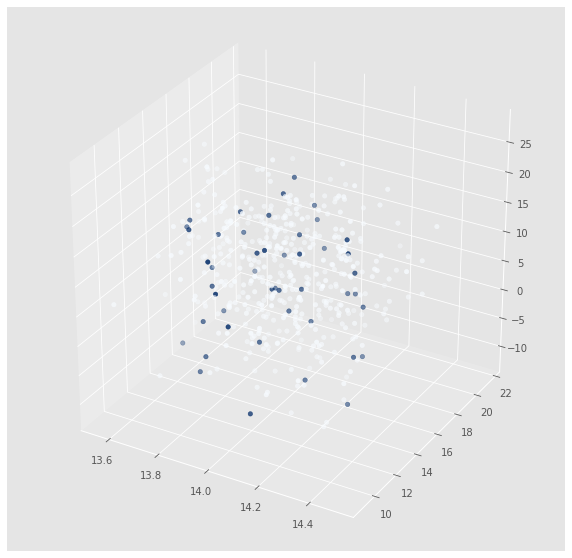

In [0]:
selection3 = SelectKBest(k=3)
df_kbest_3 = selection3.fit_transform(df.iloc[:, 2:], y=df.iloc[:, 1])
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
xdata = [x[0] for x in df_kbest_3[:500]]
ydata = [x[1] for x in df_kbest_3[:500]]
zdata = [x[2] for x in df_kbest_3[:500]]

colors = list(df[:500].target)
ax.scatter3D(xdata, ydata, zdata, c=colors, cmap='Blues');

In [0]:
combined_features = []
for x, y in zip(df_pca, df_kbest):
  combined_features.append(np.concatenate((x, y)))
combined_features = pd.DataFrame(combined_features)

In [0]:
combined_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120
0,-5.606469,-23.554409,-1.899704,5.221474,2.466672,-8.622253,2.713465,-15.071818,11.416698,1.583202,-8.810643,0.802975,1.442125,12.480842,-6.771399,-15.693868,-14.050751,2.355879,-13.959337,8.161704,0.768902,1.539386,-3.140876,-3.929022,-5.044164,-2.780605,2.671855,-3.874478,0.284329,14.927178,13.744851,-14.195228,0.764528,-4.592730,6.750446,-15.644447,-0.952110,-4.722455,2.396560,7.910377,...,0.085197,6.217201,8.837776,-5.489209,5.249674,1.682748,-0.783936,-5.109001,-3.357920,-4.690509,3.031281,-1.777108,-2.129503,-2.317407,5.582199,1.919842,-0.579323,1.648996,3.402656,3.264433,2.746974,-4.206694,-5.994232,4.141584,-7.421645,2.986590,5.354213,5.415633,1.981108,5.444945,5.1187,14.0137,-5.1488,5.1736,-2.3440,13.8372,2.0323,15.6599,11.5659,18.5618
1,34.878028,11.469291,-3.759774,-19.274506,-8.543841,6.984967,-15.539528,-2.989574,8.116709,19.065200,4.791262,-11.514892,-7.972040,-16.213782,0.054853,-8.579273,8.301577,-14.261278,-0.664824,7.534936,2.165688,10.269147,-8.707106,10.308896,-3.680804,-7.131159,-10.309095,3.276040,-14.134649,1.298947,13.193734,-1.495604,3.387545,8.695409,-10.825973,-1.899904,-6.481520,-17.123284,-17.034735,15.600825,...,3.331044,1.309392,-1.420334,6.379035,-3.806369,4.778627,1.098653,0.457219,5.081466,-5.145828,0.977441,1.555768,-1.873848,-4.411593,1.637559,-6.995692,-3.052852,6.685872,2.244896,-0.913424,-5.650777,-4.014546,-1.353984,4.540118,0.194921,-4.965494,-8.237374,-2.927568,-0.479950,-2.754613,5.6208,14.0239,-11.7684,6.6885,3.2709,18.1782,6.6203,16.1622,8.9231,30.2645
2,-4.790239,-0.334213,11.359318,8.533317,1.328571,-3.218286,22.019436,-1.662104,-4.055670,6.217987,-11.664497,-5.420168,-5.838909,-1.626875,4.860404,-10.977207,-4.695433,-14.018923,3.590142,10.547186,-13.102323,-7.174149,-5.749924,7.936096,-16.884945,9.353255,11.102433,5.877750,-0.877533,6.708694,7.056977,3.989550,-2.724309,6.890104,7.699388,-18.054204,5.966189,-6.443340,-8.022720,1.365719,...,-1.624338,-5.492391,6.981493,-6.291619,2.383189,4.403785,-1.435345,1.058824,-0.956737,1.599338,0.496149,0.536455,-1.872459,-0.141536,1.228398,1.816755,0.325430,-2.648416,7.804204,-2.135583,1.365405,0.785875,-2.829843,2.919709,3.488584,-4.364233,1.333798,1.199043,-2.043036,4.956015,6.9427,14.1929,-7.9940,6.4059,4.5048,15.7811,3.2304,8.6674,11.4934,25.6820
3,11.875370,14.050808,24.017588,-4.419429,0.372725,5.805502,20.132591,12.235285,-1.442250,-14.343129,7.999552,22.746324,4.942466,3.645703,5.698504,14.461849,10.923017,1.134816,-7.416851,-10.165267,-3.507473,-5.141825,-7.559422,-4.617944,-5.540126,6.267007,-7.895418,-1.799803,-3.818428,-3.851988,3.875660,6.465174,-2.128269,-2.498096,-4.392359,-3.131988,9.730388,-3.710759,-7.432478,-1.775938,...,3.272072,-2.839091,-3.424603,-6.268945,-7.425336,-7.084584,-2.076294,-2.995695,-3.599960,-0.257944,2.962409,-2.769238,-0.984059,0.445123,0.679267,1.818855,-6.895533,0.504862,0.108736,-1.025400,-0.305018,2.462928,-3.226782,4.923918,-4.128406,0.317418,-3.564642,2.072505,-1.778361,5.894495,5.8428,13.8463,0.8135,5.2091,11.6875,10.5404,4.2827,8.9821,10.4994,14.7483
4,52.713134,24.315340,4.334400,23.857627,-17.868964,16.346566,-15.373475,11.752637,-18.458728,-14.795923,10.218142,-13.561377,7.047135,-3.621697,-3.787832,3.067546,17.254123,4.517975,-8.437482,-18.405899,-0.629535,-2.576495,5.226259,-0.732091,6.217559,-9.273108,-6.827034,1.918704,3.031249,-2.198726,-3.790557,0.883328,2.690230,5.424953,-3.729647,-14.545226,-3.062583,-3.411238,-0.119474,4.174835,...,-1.700335,3.822139,-0.103439,-0.544171,9.538758,2.565866,-0.358631,9.527469,3.203868,-3.560096,-1.473070,-2.654762,4.163998,-1.309631,-0.513197,-7.231648,7.512688,-2.011657,0.729106,0.895544,-5.263140,-3.647652,-3.721410,-0.377687,5.721261,4.668138,-0.191238,-0.174466,2.694378,-6.055046,5.9405,13.8481,3.1

In [0]:
X = combined_features
y = df.target

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [0]:
clf = lgbm.LGBMClassifier()

In [0]:
params = {'max_depth': [-1],
          'num_leaves': [31, 10, 5],
          'learning_rate': [.1, .01],
         'n_estimators': [200, 250],
         'boosting_type':['goss']}

In [0]:
gclf = GridSearchCV(clf, cv= 3, param_grid=params, scoring='accuracy', verbose=2)

In [0]:
gclf.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] boosting_type=goss, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  boosting_type=goss, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, total=  12.3s
[CV] boosting_type=goss, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s


[CV]  boosting_type=goss, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, total=  12.5s
[CV] boosting_type=goss, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31 
[CV]  boosting_type=goss, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=31, total=  12.5s
[CV] boosting_type=goss, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=10 
[CV]  boosting_type=goss, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=10, total=   8.4s
[CV] boosting_type=goss, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=10 
[CV]  boosting_type=goss, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=10, total=   8.2s
[CV] boosting_type=goss, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=10 
[CV]  boosting_type=goss, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=10, total=   8.2s
[CV] boosting_type=goss, learning_rate=0.1, max_depth=-1, n_estimators=200, num_leaves=5 
[CV]  boosting_t

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  6.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'boosting_type': ['goss'],
                         'learni

In [0]:
gclf.best_params_

{'boosting_type': 'goss',
 'learning_rate': 0.1,
 'max_depth': -1,
 'n_estimators': 250,
 'num_leaves': 10}

In [0]:
gclf.best_score_

0.9068066666666666

In [0]:
preds = gclf.predict(X_test)

In [0]:
print(confusion_matrix(y_test, preds))

[[44830   227]
 [ 4370   573]]


In [0]:
accuracy_score(y_test, preds)

0.90806